**Credit cards default prediction models - October 2024**

Data available here : [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

Classification Report for Logistic Regression with SMOTE:

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4690
           1       0.60      0.44      0.51      1310

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.70      6000
weighted avg       0.80      0.81      0.80      6000



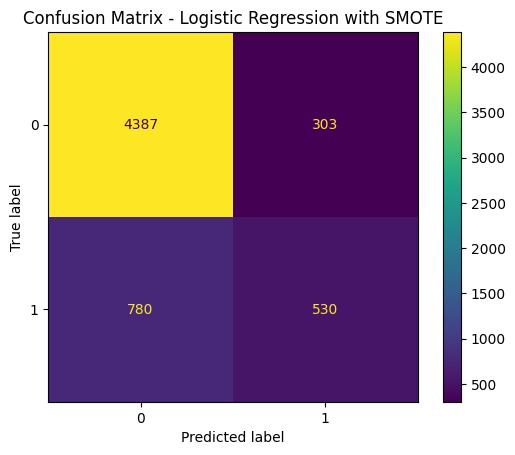

In [42]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = 'cleaned_credit_card_clients.csv'
data = pd.read_csv(file_path)

# Adjusting the headers by using the first row as the actual headers
data.columns = data.iloc[0]
data = data.drop(0)

# Renaming the target column for clarity
data = data.rename(columns={'default payment next month': 'default'})

# Converting columns to numeric, excluding the 'ID' column
cols_to_convert = data.columns.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'default'])
data[cols_to_convert] = data[cols_to_convert].apply(pd.to_numeric)

# Convert the categorical columns 'SEX', 'EDUCATION', 'MARRIAGE' to numeric
data['SEX'] = pd.to_numeric(data['SEX'])
data['EDUCATION'] = pd.to_numeric(data['EDUCATION'])
data['MARRIAGE'] = pd.to_numeric(data['MARRIAGE'])
data['default'] = pd.to_numeric(data['default'])

# Create dummy variables for 'SEX', 'EDUCATION', 'MARRIAGE'
data = pd.get_dummies(data, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True, dtype=float)

# Dropping the 'ID' column as it is not necessary for the analysis
data = data.drop('ID', axis=1)

# Scaling continuous variables
scaler = StandardScaler()
continuous_columns = cols_to_convert.tolist()
data[continuous_columns] = scaler.fit_transform(data[continuous_columns])

# Separating features (X) and target (y)
X = data.drop('default', axis=1)
y = data['default']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Applying SMOTE to balance the dataset
smote = SMOTE(sampling_strategy=0.5, random_state=101)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Fitting the logistic regression model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_res, y_train_res)

# Making predictions and evaluating the model
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Fine-tuning the probability threshold
threshold = 0.45
y_pred = (y_pred_proba >= threshold).astype(int)

report = classification_report(y_test, y_pred)

print("Classification Report for Logistic Regression with SMOTE:\n")
print(report)

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression with SMOTE")
plt.show()

In [43]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model on the resampled training data
grid_search.fit(X_train_res, y_train_res)

# Get the best estimator
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Fine-tuning the probability threshold
threshold_xgb = 0.45
y_pred_xgb = (y_pred_proba_xgb >= threshold_xgb).astype(int)

# Generate classification report
report_xgb = classification_report(y_test, y_pred_xgb)

print("Classification Report for XGBoost with SMOTE and GridSearchCV:\n")
print(report_xgb)

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.title("Confusion Matrix - XGBoost with SMOTE and GridSearchCV")
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(best_xgb_model, X_train_res, y_train_res, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

KeyboardInterrupt: 

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:05:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for Ensemble Model (Logistic Regression + XGBoost):

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4690
           1       0.56      0.48      0.52      1310

    accuracy                           0.80      6000
   macro avg       0.71      0.69      0.70      6000
weighted avg       0.80      0.80      0.80      6000



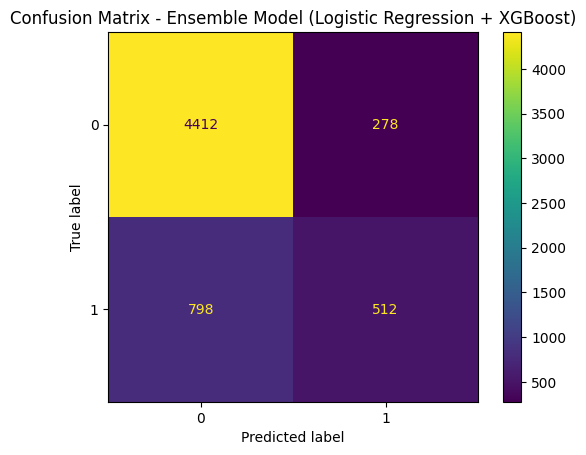

In [34]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('xgb', best_xgb_model)
    ],
    voting='soft'  # Use soft voting to consider the predicted probabilities
)

# Fit the ensemble model on the resampled training data
ensemble_model.fit(X_train_res, y_train_res)

# Make predictions on the test data
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# Fine-tuning the probability threshold
threshold_ensemble = 0.4
y_pred_ensemble = (y_pred_proba_ensemble >= threshold_ensemble).astype(int)

# Generate classification report
report_ensemble = classification_report(y_test, y_pred_ensemble)

print("Classification Report for Ensemble Model (Logistic Regression + XGBoost):\n")
print(report_ensemble)

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(ensemble_model, X_test, y_test)
plt.title("Confusion Matrix - Ensemble Model (Logistic Regression + XGBoost)")
plt.show()